Requirements:
- Python >= 3.6
- pyroomacoustics
- SciPy >= 0.18.0
- NumPy
- Cython
- pybind11
  
(where Cython is only needed to benefit from the compiled accelerated simulator. The simulator itself has a pure Python counterpart, so that this requirement could be ignored, but is much slower)

samplerate   # for resampling signals
matplotlib   # to create graphs and plots
sounddevice  # to play sound samples
mir_eval     # to evaluate performance of source separation in examples

```
pip install pyroomacoustics
```

The audio dataset that is used comes from:
[CMU ARCTIC](http://www.festvox.org/cmu_arctic/)

(0.0, 4.0)

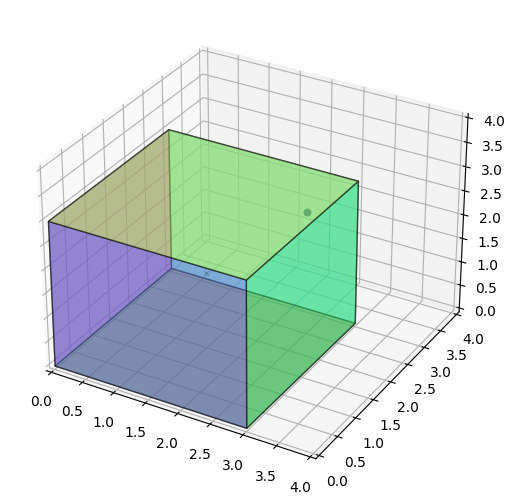

In [2]:
import pyroomacoustics as pra
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython

# specify signal source
fs, signal = wavfile.read("C:\\Users\\Alex\\source\\repos\\Data\\Sound\\arctic_a0010.wav")

# generate 2D room
corners = np.array([[0,0], [0,3.], [3.,3.], [3.,0]]).T  # [x,y]
room = pra.Room.from_corners(corners, fs=fs, max_order=3)
room.extrude(3.)

# add sound source to room
room.add_source([2.5,2.5,2.5], signal=signal)

# add microphone
mic_loc = [1.5, 1.5, 1.5]
room.add_microphone(mic_loc)

fig, ax = room.plot()
ax.set_xlim([0, 4])
ax.set_ylim([0, 4])
ax.set_zlim([0, 4])

Similarly to the image-source method, ray tracing assumes that sound energy travels around a scene in “rays”. The rays start at the sound source, and are all emitted in uniformly random directions at the same time, travelling at the speed of sound.

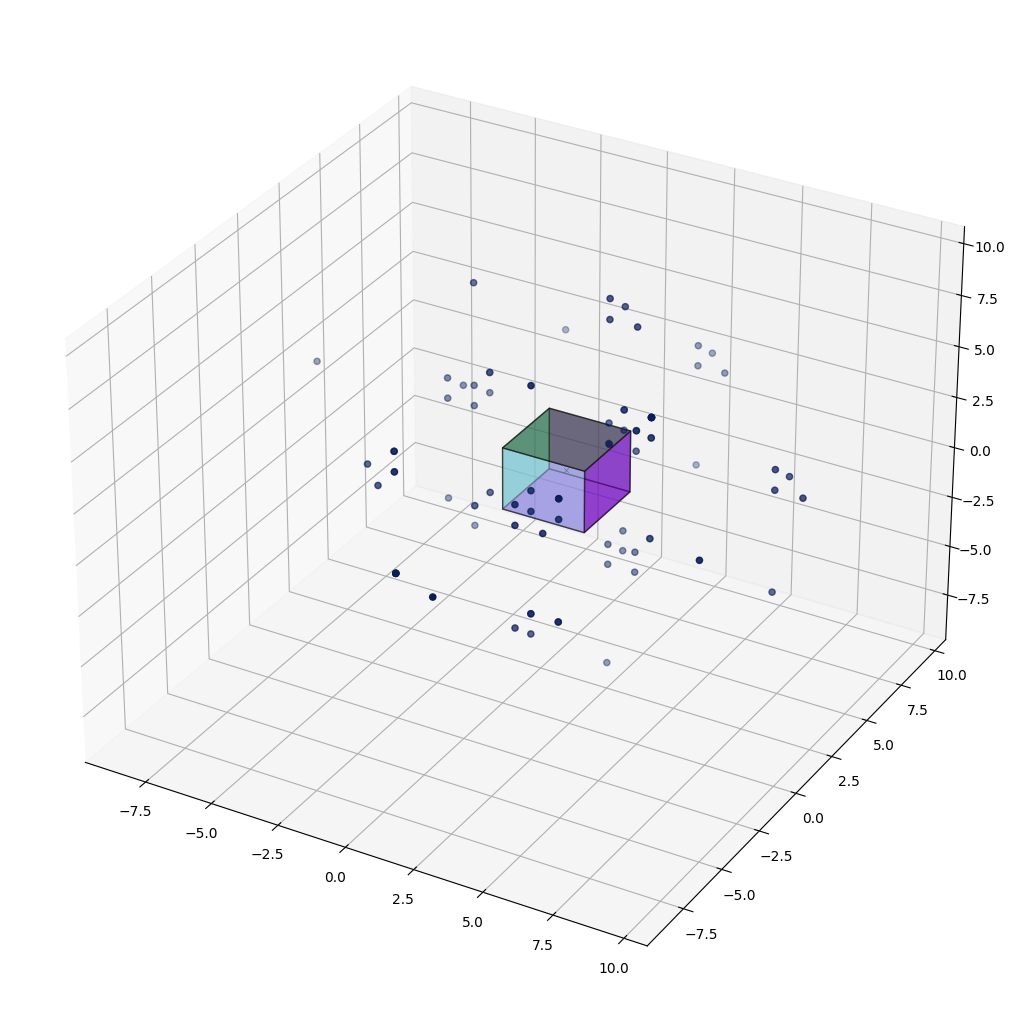

In [3]:
# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# compute image sources
room.image_source_model()

# visualize 3D polyhedron room and image sources
fig, ax = room.plot()
fig.set_size_inches(20, 10)

In [4]:
#t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=True)
#print(f"The RT60 is {t60 * 1000:.0f} ms")

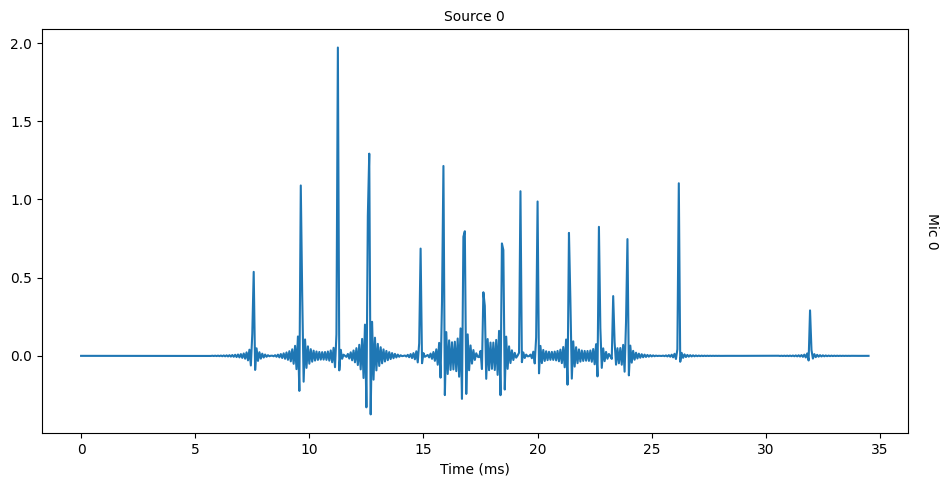

In [5]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(10, 5)

In [6]:
room.simulate()

In [7]:
# original signal
print("Original WAV:")
IPython.display.Audio(signal, rate=fs)

Original WAV:


In [8]:
print("Simulated propagation to first mic:")
IPython.display.Audio(room.mic_array.signals[0,:], rate=fs)

Simulated propagation to first mic:


How to use this to get the DOA.
Pyroomacoustics has some standard mathematical models that can estimate this (SRP-PHAT, MUSIC, CSSM, WAVES, TOPS, and FRIDA)

In [9]:
# Location of source
azimuth = np.array([270.]) / 180. * np.pi # convert to radians
distance = 1.5  # meters

c = 343.    # speed of sound
fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_range = [300, 3500]
snr_db = 5.    # signal-to-noise ratio
sigma2 = 10**(-snr_db / 10) / (4. * np.pi * distance)**2

# Create an anechoic room
room_dim = np.r_[5.,5.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

# add microphone
microphones = np.c_[[2.55, 2.55],[ 2.45, 2.45]]
#echo = pra.circular_2D_array(center=room_dim/2, M=6, phi0=0, radius=37.5e-3)
#echo = np.concatenate((echo, np.array(room_dim/2, ndmin=2).T), axis=1)

# add sources
rng = np.random.RandomState(23)
duration_samples = int(fs)
source_location = room_dim / 2 + distance * np.r_[np.cos(azimuth), np.sin(azimuth)]
source_signal = rng.randn(duration_samples)
aroom.add_source(source_location, signal=source_signal)

aroom.add_microphone_array(microphones)
#aroom.add_microphone_array(pra.MicrophoneArray(echo, aroom.fs))

# Run the simulation
aroom.simulate()

In [11]:
IPython.display.Audio(source_signal, rate=fs)

In [12]:
X = pra.transform.stft.analysis(aroom.mic_array.signals.T, nfft, nfft // 2)
X = X.transpose([2, 1, 0])

In [13]:
algo_names = ['MUSIC', 'TOPS']
spatial_resp = dict()

# loop through algos
for algo_name in algo_names:
    # Construct the new DOA object
    doa = pra.doa.algorithms[algo_name](microphones, fs, nfft, c=c, num_src=1)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_range=freq_range)
    
    # store spatial response
    spatial_resp[algo_name] = doa.grid.values
        
    # normalize   
    min_val = spatial_resp[algo_name].min()
    max_val = spatial_resp[algo_name].max()
    spatial_resp[algo_name] = (spatial_resp[algo_name] - min_val) / (max_val - min_val)

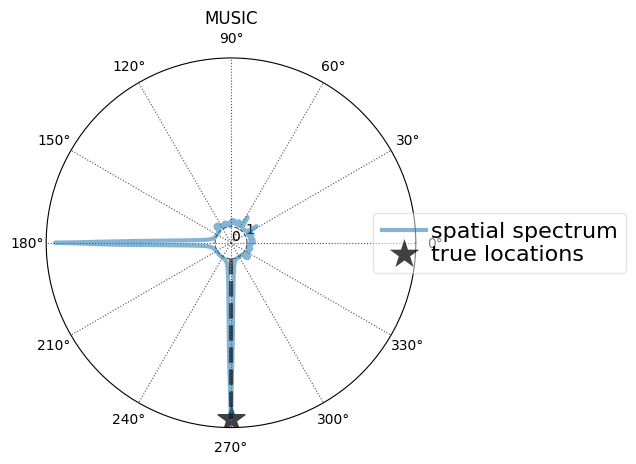

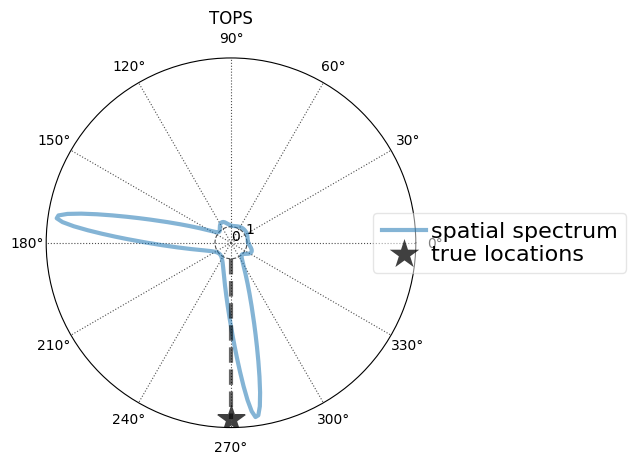

In [14]:
# plotting param
base = 1.
height = 10.
true_col = [0, 0, 0]

# loop through algos
phi_plt = doa.grid.azimuth
for algo_name in algo_names:
    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    c_phi_plt = np.r_[phi_plt, phi_plt[0]]
    c_dirty_img = np.r_[spatial_resp[algo_name], spatial_resp[algo_name][0]]
    ax.plot(c_phi_plt, base + height * c_dirty_img, linewidth=3,
            alpha=0.55, linestyle='-',
            label="spatial spectrum")
    plt.title(algo_name)
    
    # plot true loc
    for angle in azimuth:
        ax.plot([angle, angle], [base, base + height], linewidth=3, linestyle='--',
            color=true_col, alpha=0.6)
    K = len(azimuth)
    ax.scatter(azimuth, base + height*np.ones(K), c=np.tile(true_col,
               (K, 1)), s=500, alpha=0.75, marker='*',
               linewidths=0,
               label='true locations')

    plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, framealpha=0.5,
              scatterpoints=1, loc='center right', fontsize=16,
              ncol=1, bbox_to_anchor=(1.6, 0.5),
              handletextpad=.2, columnspacing=1.7, labelspacing=0.1)

    ax.set_xticks(np.linspace(0, 2 * np.pi, num=12, endpoint=False))
    ax.xaxis.set_label_coords(0.5, -0.11)
    ax.set_yticks(np.linspace(0, 1, 2))
    ax.xaxis.grid(visible=True, color=[0.3, 0.3, 0.3], linestyle=':')
    ax.yaxis.grid(visible=True, color=[0.3, 0.3, 0.3], linestyle='--')
    ax.set_ylim([0, 1.05 * (base + height)])